## RNN, the fisrt impact!

In this tutorial we will study the followings:
* Common data preparation routine for RNNs
* Defining RNN model
* Many-to-Many prediciton of RNN
* Rollout prediction based on boostraping

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

Let's generate our toy data with sine wave.

In [2]:
def generate_sin(n_samples):
    xs = np.linspace(start=0, stop=100 * np.pi, num=n_samples)
    ys = np.sin(xs)
    return xs, ys

In [8]:
x_data, y_data = generate_sin(5000)

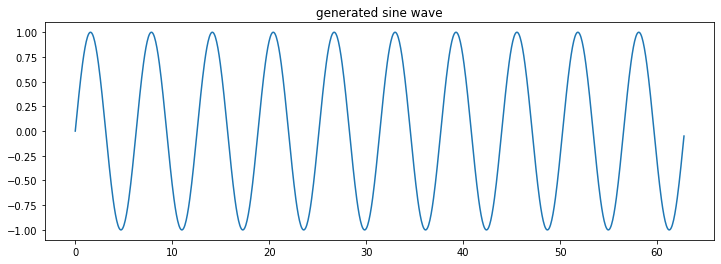

In [39]:
fig, ax = plt.subplots(1,1, figsize=(12,4))
ax.plot(x_data[:1000], y_data[:1000])
plt.title("generated sine wave")
plt.show()

In [16]:
target_seq = y_data
seq_len = 30

## Common data preparation steps for RNN training

<center><img src="img/rnn_data_prep.png" width="500" height="300"><em>Data prepartion step for RNN with sliding window method</em></center>

Commonly in practice, we only have __1__ realziation of stochastic autogressive process. In that setting, we employ 'sliding window' to generate (or prepare) data for training RNNs.

In [18]:
x =[target_seq[i: i+seq_len] for i in range(0,len(target_seq))][:-seq_len]
y =[target_seq[i: i+seq_len] for i in range(1,len(target_seq))][:-seq_len]

In [19]:
x = torch.Tensor(x).reshape(-1, seq_len, 1).float()
y = torch.Tensor(y).reshape(-1, seq_len, 1).float()

## Train / test set split

<center><img src="img/train_test_rnn.png" width="500" height="300"><em>Train / Test split </em></center>

Since we have only 1 realization, we need to split the process into two part to __train__ and __test__ RNN models. In this tutorial, we use apporximatly 80% of data as the training set and the reaminig 20% as the test dataset.

In [29]:
import math

num_train_set = math.floor(X.shape[0] * 0.8)

X_train = X[:num_train_set,:, :]
Y_train = Y[:num_train_set, :, :]

X_test = X[num_train_set:,:, :]
Y_test = Y[num_train_set:,:, :]

In [25]:
class LSTM(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.rnn = nn.LSTM(input_size, hidden_dim, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_size)
        
    def init_hiddens(self, batch_size):
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        cell = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        return hidden, cell
    
    def forward(self, x, hidden=None, cell=None):
        if hidden is None and cell is None:
            batch_size = x.size(0)
            hidden, cell = self.init_hiddens(batch_size)
        
        out, (hidden, cell) = self.rnn(x, (hidden, cell))
        out = self.fc(out)
        return out, hidden, cell
    
    def rollout(self, x_inits, x_start,  n_rollouts=100):
        _, hidden, cell = self.forward(x_inits)
        
        traj = []
        for i in range(n_rollouts):
            x, hidden, cell = self.forward(x, hidden, cell)
            traj.append(x.detach().numpy().squeeze())
        return traj            

## Training method: Many-to-Many
<br/>

<center><img src="img/many_to_many_training.png" width="400" height="200"><em>Many-to-Many training </em></center>

In [26]:
model = LSTM(input_size=1, output_size=1, hidden_dim=100, n_layers=1)
loss_fn = nn.MSELoss()
n_epochs = 100
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [27]:
def train(X_train, Y_train, n_epochs, lr, print_every=100):
    for epoch in range(n_epochs):
        losses = []
        output, hidden, cell = model(X_train)
        optimizer.zero_grad()
        loss = loss_fn(output, Y_train)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if epoch % print_every == 0:
            print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
            print("Loss: {}".format(np.array(losses).mean()))

In [52]:
train(X_train, Y_train, 1000, lr)

Epoch: 1/500............. Loss: 0.004080585669726133
Epoch: 101/500............. Loss: 0.0025564953684806824
Epoch: 201/500............. Loss: 0.001468899194151163
Epoch: 301/500............. Loss: 0.0007505947723984718
Epoch: 401/500............. Loss: 0.0003857671981677413


## Predicting 'near' future with RNN

<center><img src="img/near_future_pred.png" width="500" height="300"><em>Predicting near future</em></center>

In [32]:
y_preds, hidden, cell = model.forward(X_test)

y_hat = [y_pred[-1,:].squeeze().detach().numpy() for y_pred in y_preds]
y_truth = [y_train[-1,:].squeeze().detach().numpy() for y_train in Y_test]

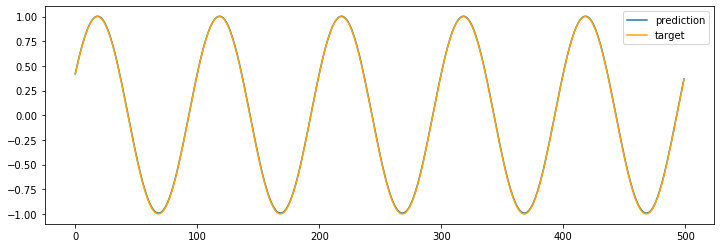

In [43]:
VIZ_START = 0
VIZ_END = 500

fig, ax = plt.subplots(1,1, figsize=(12,4))
ax.plot(y_hat[VIZ_START:VIZ_END], label='prediction')
ax.plot(y_truth[VIZ_START:VIZ_END], label='target', color='orange')
ax.legend()
plt.show()

## Predicting 'far' futre with RNN

Predicting future value for just next time stamp is less attractive in practice. Now we will use RNN to predict the future trajectory with boostrapped predictions.

<center><img src="img/far_future_pred.png" width="500" height="300"><em>Predicting far future</em></center>

In [57]:
n_inits = 400
_, rollout_targets = generate_sin(5000)
x_init = torch.Tensor(rollout_targets[:n_inits]).reshape(1, n_inits, 1)

n_rollouts = 500

x_init = x_init.reshape(1,-1,1)
x = torch.Tensor((rollout_targets[n_inits],)).reshape(1,1,1)
y = rollout_targets[n_inits: n_inits+n_rollouts]

out, hidden, cell = model(x_init)
traj = []
for i in range(n_rollouts):
    x, hidden, cell = model.forward(x, hidden, cell)
    traj.append(x.detach().numpy().squeeze())

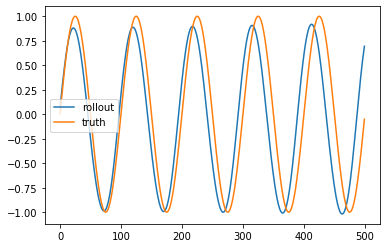

In [58]:
plt.plot(traj, label='rollout')
plt.plot(y, label='truth')
plt.legend()